## Importing Necessary Libraries

In [35]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

## Static Information

confirmed_global = 'data/time_series_covid19_confirmed_global.csv'
deaths_global = 'data/time_series_covid19_deaths_global.csv'
recovered_global = 'data/time_series_covid19_recovered_global.csv'

## Helper functions needed

In [35]:
def import_data(path):
    df = pd.read_csv(path)
    return df 

In [81]:
def create_monthly_analysis(df):
    years = ['20','21','22']
    months_mapping = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    century = '20'
    months = [i for i in range(1,13)]
    static_columns = ['Province/State', 'Country/Region', 'Lat', 'Long']
    date_columns = [j for j in df.columns if j not in static_columns]
    df_months = df.copy()
    # df_months['tilldate'] = 0
    for year in years:
        for month in months:
            date_month = str(month)+'/'+str(year)
            str_date_month = months_mapping[month] + ' ' +str(century)+str(year)
            df_months[str_date_month] = 0
            for i in df_months.columns:
                datematch = rf"{month}/\d{{1,2}}/{year}"
                date = re.compile(datematch)
                matched = date.search(str(i))
                if matched != None:
                    df_months[str_date_month] = df_months[i].astype(int) + df_months[str_date_month]
            # df_months['tilldate'] = df_months[date_month] + df_months['tilldate']
    df_months = df_months.drop(columns = date_columns, axis = 1)
    df_countries = df_months['Country/Region']
    stale_columns = ['Apr 2022','May 2022','Jun 2022','Jul 2022','Aug 2022','Sep 2022','Oct 2022','Nov 2022','Dec 2022', 'Province/State', 'Lat', 'Long']
    # stale_columns = ['Apr 2022','May 2022','Jun 2022','Jul 2022','Aug 2022','Sep 2022','Oct 2022','Nov 2022','Dec 2022', 'Lat', 'Long']
    # stale_columns =  ['Province/State', 'Lat', 'Long']
    df_months = df_months.drop(columns = stale_columns, axis = 1)
    df_months = df_months.set_index('Country/Region')
    #Total sum per row: 
    df_months.loc['global',:]= df_months.sum(axis=0)
    #Total sum per row: 
    df_months.loc[:,'tilldate'] = df_months.sum(axis=1)
    # df_months['Country/Region'] = df_countries
    return df_months

In [80]:
def plot_line_graph(x,y,title,xlabel,ylabel, color='blue', rotation=90, subplot_num=None, axis = None, fillcolor='skyblue',figsize=(10,5)):
    # importing libraries
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    
    if axis == None:
        figure, axis = plt.subplots(1, 1, figsize=figsize)
    if subplot_num != None:
        axis = axis[subplot_num]
    axis.plot(x, y, color =color)
    axis.set_title(title)
    plt.setp(axis.get_xticklabels(), rotation=rotation)
    plt.fill_between(x, y, alpha=0.4, color=fillcolor)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    current_values = plt.gca().get_yticks()
    axis.set_yticklabels(['{:.0f}'.format(x) + 'M' for x in plt.gca().get_yticks()/1E6])
    plt.show()
 

## Loading Input Data

In [35]:
confirmed_df = import_data(confirmed_global)
deaths_df = import_data(deaths_global)
recovered_df = import_data(recovered_global)

## Creating monthly analysis for confirmed cases and deaths observed

In [37]:
confirmed_monthly = create_monthly_analysis(confirmed_df)
deaths_monthly = create_monthly_analysis(deaths_df)
recovered_monthly = create_monthly_analysis(recovered_df)

### Creating global time series data 

In [38]:
global_table = pd.DataFrame(columns = ['Jan 2020', 'Feb 2020', 'Mar 2020', 'Apr 2020', 'May 2020', 'Jun 2020',
       'Jul 2020', 'Aug 2020', 'Sep 2020', 'Oct 2020', 'Nov 2020', 'Dec 2020',
       'Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021', 'Jun 2021',
       'Jul 2021', 'Aug 2021', 'Sep 2021', 'Oct 2021', 'Nov 2021', 'Dec 2021',
       'Jan 2022', 'Feb 2022', 'Mar 2022'])
global_table.loc['confirmed'] = confirmed_monthly.loc['global']
global_table.loc['deaths'] = deaths_monthly.loc['global']
global_table.loc['recoveries'] = recovered_monthly.loc['global']
global_table.head()

,Jan 2020,Feb 2020,Mar 2020,Apr 2020,May 2020,Jun 2020,Jul 2020,Aug 2020,Sep 2020,Oct 2020,...,Jun 2021,Jul 2021,Aug 2021,Sep 2021,Oct 2021,Nov 2021,Dec 2021,Jan 2022,Feb 2022,Mar 2022
confirmed,1.648720e+09,2.299324e+09,9095197.0,63566312.0,145038098.0,246692701.0,431675990.0,672051282.0,895460493.0,1.229538e+09,...,5.320074e+09,5.896146e+09,6.466674e+09,6.811819e+09,7.473037e+09,7.656678e+09,8.496019e+09,1.027559e+10,1.157139e+10,5.371252e+09
deaths,4.155258e+07,5.302418e+07,401575.0,4422694.0,10004663.0,13983464.0,19316987.0,25085170.0,29554145.0,3.587342e+07,...,1.147672e+08,1.266275e+08,1.356262e+08,1.398839e+08,1.518097e+08,1.534248e+08,1.654586e+08,1.721260e+08,1.633355e+08,7.205711e+07
recoveries,1.065637e+09,1.366132e+09,2705110.0,16314536.0,54100868.0,118880540.0,242238461.0,423525878.0,608664203.0,8.432717e+08,...,3.440040e+09,3.868309e+09,5.217530e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


#### PLotting the global trends 

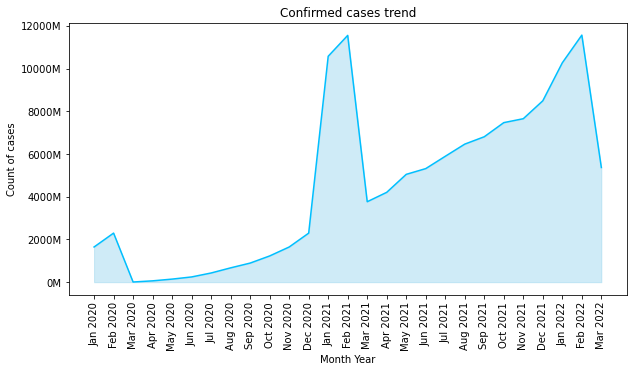

In [75]:
plot_line_graph(global_table.columns, global_table.loc['confirmed'].values.tolist(),'Confirmed cases trend', 'Month Year', 'Count of cases', color='deepskyblue', fillcolor='skyblue')

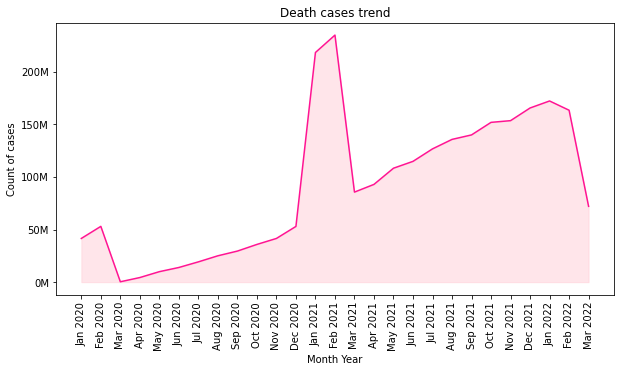

In [77]:
plot_line_graph(global_table.columns, global_table.loc['deaths'].values.tolist(),'Death cases trend', 'Month Year', 'Count of cases', color='deeppink', fillcolor='pink')

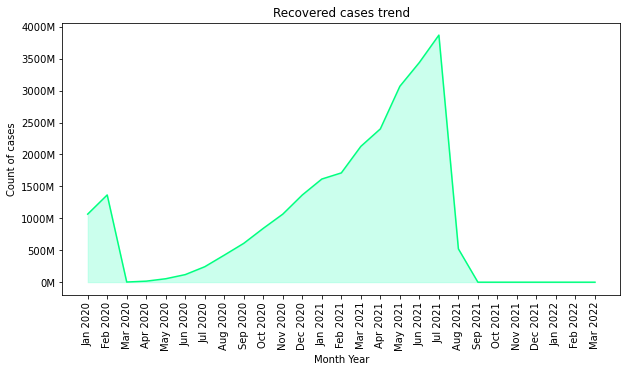

In [78]:
plot_line_graph(global_table.columns, global_table.loc['recoveries'].values.tolist(),'Recovered cases trend', 'Month Year', 'Count of cases', color='springgreen', fillcolor='aquamarine')

### Obtaining country wise summary figures

In [134]:
country_wise_total_df = pd.DataFrame(columns=['confirmed','deaths'])
# country_wise_total_df['rec'] = recovered_monthly['tilldate']
country_wise_total_df['confirmed'] = confirmed_monthly['tilldate']
country_wise_total_df['deaths'] = deaths_monthly['tilldate']
country_wise_total_df = country_wise_total_df.join(pd.DataFrame(recovered_monthly['tilldate']))
country_wise_total_df = country_wise_total_df.rename(columns={"tilldate":"recoveries"})
country_wise_total_df.head()

,confirmed,deaths,recoveries
Country/Region,,,
Afghanistan,72250685.0,3162879.0,20556405.0
Albania,87369182.0,1437660.0,23895960.0
Algeria,103242319.0,2929040.0,28946709.0
Andorra,9720770.0,83381.0,3438603.0
Angola,27928672.0,665886.0,6378643.0


#### Plotting significant Information about countries data obtained